In [1]:
import requests
import json
import os
from dotenv import load_dotenv
from pathlib import Path


load_dotenv('logstuff.env')


username = os.environ.get('user')
password = os.environ.get('password')

app_id = os.environ.get('app_id')
secret = os.environ.get('secret')
useragent = os.environ.get('useragent')

auth = requests.auth.HTTPBasicAuth(app_id, secret)

print(auth)

# here we pass our login method (password), username, and password
data = {'grant_type': 'password',
        'username': username,
        'password': password}

# setup our header info, which gives reddit a brief description of our app
headers = {'User-Agent': useragent}

# send our request for an OAuth token
authresponse = requests.post('https://www.reddit.com/api/v1/access_token',
                    auth=auth, data=data, headers=headers)

# convert response to JSON and pull access_token value
TOKEN = authresponse.json()['access_token']

# add authorization to our headers dictionary
headers = {**headers, **{'Authorization': f"bearer {TOKEN}"}}

# while the token is valid (~2 hours) we just add headers=headers to our requests
requests.get('https://oauth.reddit.com/api/v1/me', headers=headers)

print(authresponse)

<Response [200]>


In [2]:
authresponse.json()

{'access_token': '22158216-JyeuJizI9vQCbCxL4T73iofQ3lnvTw',
 'token_type': 'bearer',
 'expires_in': 3600,
 'scope': '*'}

In [3]:
response = requests.get("https://oauth.reddit.com/r/politics/hot",
                   headers=headers)

print(response)
print(response.json())  # let's see what we get


<Response [200]>
{'kind': 'Listing', 'data': {'after': 't3_tp0fam', 'dist': 27, 'modhash': None, 'geo_filter': None, 'children': [{'kind': 't3', 'data': {'approved_at_utc': None, 'subreddit': 'politics', 'selftext': "It's Saturday, folks. Let's all kick back with a cup of coffee and share some cartoons!\n\nFeel free to share political cartoons in this thread. Besides our usual civility policy, there are three rules to follow:\n\n1. **Every top-level comment must contain a political cartoon.** This means no text-only top-level comments.\n2. **It must be an _original cartoon_**. This means no photographs, no edited cartoons, no templates, no memes and no image macros. OC is allowed, as is animation.\n3. **Each top-level comment should only have a maximum of 3 cartoons.** \n\nThat's all. Enjoy your weekend!", 'author_fullname': 't2_d5h4t', 'saved': False, 'mod_reason_title': None, 'gilded': 0, 'clicked': False, 'title': 'Saturday Morning Political Cartoon Thread', 'link_flair_richtext': [

In [4]:
count = 0

for post in response.json()['data']['children']:
    print(post['data']['title'])
    print('\n')
    count += 1
    
    
print(count)

Saturday Morning Political Cartoon Thread


Discussion Thread: President Biden gives an address from Poland


Sen. Blumenthal: Supreme Court Justice Clarence Thomas should appear before Jan 6 panel


We Have New Evidence of Saudi Involvement in 9/11, and Barely Anyone Cares


Mitch McConnell says he has ' total confidence in ' Justice Thomas ' impartiality after it was revealed that his wife texted about overturning the 2020 election with Trump's chief of staff


President Biden to unveil new minimum tax on billionaires in budget


Thomas scrutiny intensifies after latest revelations


We Have Two Political Parties and One of Them Has Gone Insane


Calls for Clarence Thomas Recusal Intensify in Wake of Wife's 1/6 Texts


Trump backers push election change that would make counting slower, costlier and less accurate


President Joe Biden to propose new 20% minimum billionaire tax


Sanders Intros Revival of 95% Windfall Profits Tax From WWII to Curb Corporate Greed


Mitt Romney riles up

In [5]:
import praw
# import print

reddit = praw.Reddit(
    client_id=app_id,
    client_secret=secret,
    user_agent=useragent,
    username=username,
    password=password
)
print(reddit) # Output: True

In [6]:
from datetime import datetime
import pandas as pd
from praw.models import MoreComments

url = "https://www.reddit.com/r/worldnews/comments/ti0564/link_found_between_vaccine_resistance_sympathy/"
submission = reddit.submission(url=url)

df = pd.DataFrame(columns = ['Name', 'TotalKarma', 'CommentKarma', 'DateTime', 'DateTimeComment',
                             'AdjustedKarma', 'AdjustedKarmaPercent'])

for comment in submission.comments:
    try:
        if isinstance(comment, MoreComments):
            continue
        if comment.author is None:
                continue
        elif comment.author.comment_karma == 0:
                continue
        else:
            timestamp = comment.author.created_utc
            timestampcomment = comment.created_utc
            convertedDate = datetime.fromtimestamp(timestamp)
            convertedDateComment = datetime.fromtimestamp(timestampcomment)
            df = df.append({'Name' : comment.author, 'TotalKarma' : comment.author.comment_karma, 'CommentKarma' : comment.score, 
                            'DateTime' : convertedDate, 'DateTimeComment' : timestampcomment,
                            'AdjustedKarma' : -(comment.score - comment.author.comment_karma),
                           'AdjustedKarmaPercent' : comment.score / comment.author.comment_karma}, 
                           ignore_index = True)    
    except AttributeError:
        print("Attribute error for " + str(comment))
        continue
    
df.head()

Attribute error for i1ax92u


,Name,TotalKarma,CommentKarma,DateTime,DateTimeComment,AdjustedKarma,AdjustedKarmaPercent
0,lubeste,4965,514,2018-11-30 00:29:34,1.647713e+09,4451,0.103525
1,RbnMTL,5758,4207,2014-12-28 14:09:57,1.647713e+09,1551,0.730636
2,SpicyPandaBalls,74706,1960,2021-07-01 09:12:10,1.647711e+09,72746,0.026236
3,namesTaken_gfsdgfdsg,1324,833,2022-03-10 06:18:36,1.647713e+09,491,0.629154
4,H3r0d0tu5,7110,39,2019-06-20 09:14:43,1.647713e+09,7071,0.005485


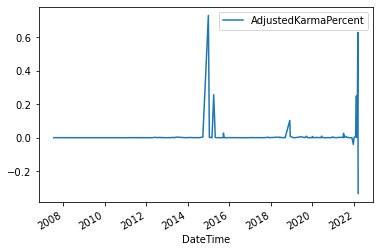

In [7]:
import matplotlib.pyplot as plt
plt.close("all")


yAxis = pd.Series(df['AdjustedKarmaPercent'])
xAxis = pd.Series(df['DateTime'])

ts = pd.Series(yAxis, index = xAxis)
ts.head()

sortdf = df.sort_values(by=['DateTime'])

sortdf.plot(x = 'DateTime', y = 'AdjustedKarmaPercent')
plt.gcf().autofmt_xdate()
plt.show()



In [8]:
from datetime import datetime, timedelta

today = datetime.now()
start_date = today - timedelta(days = 30)
end_date = today

condition = (sortdf['DateTime'] >= start_date) & (sortdf['DateTime'] <= end_date)
newAccounts = sortdf.loc[condition]
newAccounts.head(150)

,Name,TotalKarma,CommentKarma,DateTime,DateTimeComment,AdjustedKarma,AdjustedKarmaPercent
73,safetymole,325,2,2022-02-26 18:09:33,1.647726e+09,323,0.006154
3,namesTaken_gfsdgfdsg,1324,833,2022-03-10 06:18:36,1.647713e+09,491,0.629154
108,No_Adhesiveness_6381,-6,2,2022-03-15 23:40:33,1.647739e+09,-8,-0.333333
103,No_Adhesiveness_6381,-6,2,2022-03-15 23:40:33,1.647731e+09,-8,-0.333333


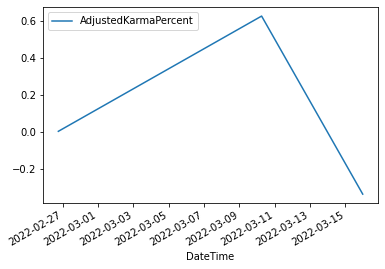

In [9]:
yAxis = pd.Series(newAccounts['AdjustedKarmaPercent'])
xAxis = pd.Series(newAccounts['DateTime'])

ts = pd.Series(yAxis, index = xAxis)
ts.head()


newAccounts.plot(x = 'DateTime', y = 'AdjustedKarmaPercent')
plt.gcf().autofmt_xdate()
plt.show()

In [10]:
response = requests.get("https://oauth.reddit.com/r/politics/hot", headers=headers)

threadList = []


for post in response.json()['data']['children']:
    x = str(post['data']['name'])
    x = x.split('_')
    threadList.append(x[1])

def getSubComments(comment, allComments, verbose=True):

    allComments.append(comment)
    if not hasattr(comment, "replies"):
        replies = comment.comments()
        if verbose: print("fetching (" + str(len(allComments)) + " comments fetched total)")
    else:
        replies = comment.replies
    for child in replies:
        getSubComments(child, allComments, verbose=verbose)    
    
    
def getAll(r, submissionId, verbose=True):
    submission = r.submission(submissionId)
    comments = submission.comments
    commentsList = []
    getSubComments(comment, commentsList, verbose=verbose)
    return commentsList
  

In [11]:
#res = getAll(reddit, 'tk86b5')
#threadList = threadList[0:1]

df2 = pd.DataFrame(columns = ['Name', 'TotalKarma', 'CommentLength', 'AccountDateTime',
                              'CommentDateTime', 'ThreadDateTime', 'CommentKarma', 'AdjustedKarma', 
                              'AdjustedKarmaPercent' ])    
bannedAccounts =open('BannedAccounts.txt', 'a')

today = datetime.now()
start_date = today - timedelta(days = 30)

for url in threadList:
    # this is to let me know it's actually iterating
    print('tick')
    res = reddit.submission(url)
    submissionDateTime = datetime.fromtimestamp(res.created_utc)
    for comment in res.comments:
        if isinstance(comment, MoreComments):
            continue
        try:
            accountDateTime = datetime.fromtimestamp(comment.author.created_utc)
            commentDateTime = datetime.fromtimestamp(comment.created_utc)
            if comment.author is None:
                continue
            elif comment.author.comment_karma == 0:
                continue
            #elif convertedDate <= start_date:
                #print(convertedDate)
                #continue
            else:
                df2 = df2.append({'Name' : comment.author, 'TotalKarma' : comment.author.comment_karma, 
                                  'CommentKarma' : comment.score, 'CommentDateTime' : commentDateTime,
                                  'AdjustedKarma' : -(comment.score - comment.author.comment_karma),
                                  'AdjustedKarmaPercent' : comment.score / comment.author.comment_karma,
                                  'ThreadDateTime' : submissionDateTime, 'AccountDateTime' : accountDateTime,
                                  'CommentLength' : len(comment.body)}, ignore_index = True)
        except AttributeError:
            print("Attribute error for " + str(comment))
            write = ['Author of comment ', str(comment), ', ', str(comment.author), 
                     ', in thread ', str(res.name), '(', str(res.title), ')', ' shows as a banned account \n']
            bannedAccounts.writelines(write)
            continue


bannedAccounts.close()        
    
df2.head(500)

tick
tick
Attribute error for i289r4t
Attribute error for i27pnnm
tick


KeyboardInterrupt: 

In [ ]:
print(len(df2))

In [ ]:
from os.path import exists

df2.to_csv('out.csv', index = False)

if exists('cumulativeout.csv'):
    df2.to_csv('cumulativeout.csv', mode = 'a', index = False, header = False)
    print('appending to cumulativeout.csv')
else:
    df2.to_csv('cumulativeout.csv', index = False)
    print("started new cumulativeout.csv!")